In [1]:
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from matplotlib.pyplot import imshow
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def RGBtoYCC(arr):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = arr.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [3]:
def YCCtoRGB(arr):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = arr.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [4]:
def RGBtoGray(arr):
    ycc = RGBtoYCC(arr)
    ret = np.zeros_like(ycc)
    ret[:, :, 0] = ycc[:, :, 0]
    ret[:, :, 1] = ycc[:, :, 0]
    ret[:, :, 2] = ycc[:, :, 0]
    return ret

In [5]:
def YCCtoGray(arr):
    ret = np.zeros_like(arr)
    ret[:, :, 0] = arr[:, :, 0]
    ret[:, :, 1] = arr[:, :, 0]
    ret[:, :, 2] = arr[:, :, 0]
    return ret

In [6]:
def crop_center(img, cropx, cropy):
    y, x, C = img.shape
    if y > cropy and x > cropx:
        startx = x//2 - (cropx//2)
        starty = y//2 - (cropy//2)    
        return img[starty:starty+cropy, startx:startx+cropx, :]
    else:
        return None

In [7]:
train_dir = './train2017/'

image_names = os.listdir(train_dir)
print(len(image_names))

%matplotlib inline

117285


In [8]:
# some of the images might not be the right size
# these are the dimenions with which we are working
H = 256
W = 256
C = 3
Q = 300
bins = np.asarray([i / Q for i in range(Q)])
inverse_values = bins + 1 / (Q * 2)

In [9]:
def process_image(arr, H, W, C, Q):
    if len(arr.shape) == 3:
        cropped = crop_center(arr, H, W)
        if cropped is not None:
            arr = RGBtoYCC(cropped)
            arr = np.divide(arr, 255)
            gray = YCCtoGray(arr)
            arr = arr[:, :, 1:]
            original = np.copy(arr)
            digitized = np.digitize(arr, bins)
            targets = digitized.reshape(-1)
            targets -= 1
            one_hot_targets = np.eye(Q)[targets]
            one_hot_targets = one_hot_targets.reshape((H * W * (C-1), Q))
            return gray, original, one_hot_targets
        return None, None, None
    return None, None, None

In [10]:
used = []
def generator(image_folder, batch_size):
    batch_features = np.zeros((batch_size, H, W, C))
    batch_labels = np.zeros((batch_size, H * W * (C - 1), Q))
    
    filenames = os.listdir(image_folder)
    
    while True:
        count = 0
        while count < batch_size:
            filename = random.choice(filenames)
            arr = np.load(os.path.join(image_folder, filename))
            x, original, binned = process_image(arr, H, W, C, Q)
            if x is not None:
                used.append(filename)
                batch_features[count, :, :, :] = x
                batch_labels[count, :, :] = bins
                count += 1
        yield batch_features, batch_labels

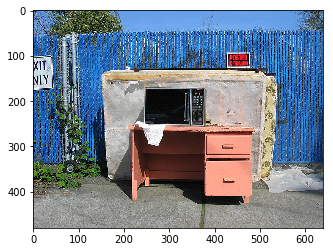

In [11]:
random_example = np.load("./train2017/000000436023.npy")
imshow(random_example)

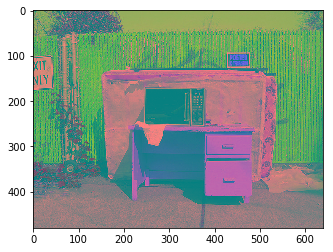

In [12]:
imshow(RGBtoYCC(random_example))

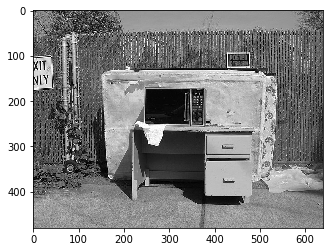

In [13]:
imshow(RGBtoGray(random_example))

In [14]:
x, y, binned = process_image(random_example, H, W, C, Q)

(256, 256, 3)


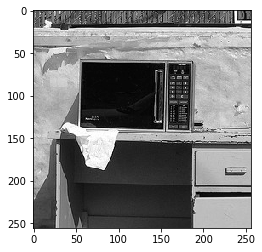

In [15]:
# the x
print(x.shape)
imshow(x)

In [16]:
print(binned.shape)

(131072, 300)


(256, 256, 2)


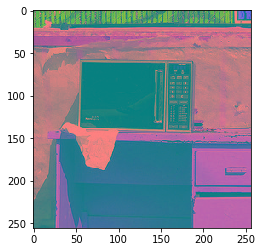

In [17]:
# the y
showing = np.zeros((y.shape[0], y.shape[1], y.shape[2] + 1))
print(y.shape)
showing[:, :, 0] = x[:, :, 0]
showing[:, :, 1:] = y
imshow(showing)

In [18]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 10

print('Using device: ', device)

Using device:  /device:GPU:0


In [19]:
model_file = 'model.json'
weights_file = 'weights.h5'
model_path = os.path.join("./", model_file)
weights_path = os.path.join("./", weights_file)
use_saved = False
save = True
train = True

In [68]:
def my_loss_function(y_true, y_pred):
    _, P, Q = y_pred.get_shape().as_list()
    y_true = tf.keras.backend.reshape(y_true, (-1, Q))
    y_pred = tf.keras.backend.reshape(y_pred, (-1, Q))
    logs = tf.keras.backend.log(y_pred)
    losses = y_true * logs
    losses = -tf.keras.backend.mean(losses, axis=1)
    losses = tf.keras.backend.reshape(losses, (-1, P))
    losses = tf.keras.backend.sum(losses, axis=1)
    return tf.keras.backend.mean(losses)

def my_loss_function_np(y_true, y_pred):
    _, P, Q = y_pred.shape
    y_true = np.reshape(y_true, (-1, Q))
    y_pred = np.reshape(y_pred, (-1, Q))
    logs = np.log(y_pred)
    losses = y_true * logs
    losses = -np.mean(losses, axis=1)
    losses = np.reshape(losses, (-1, P))
    losses = np.sum(losses, axis=1)
    return np.mean(losses)

In [72]:
input_shape = (H, W, C)


model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                    input_shape=input_shape)
for layer in model.layers:
    layer.trainable = False

inter_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
inter1 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[0]).output)
inter2 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[1]).output)
inter3 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[2]).output)
inter4 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[3]).output)

inter1_scale = H // inter1.output_shape[1]
inter2_scale = H // inter2.output_shape[1]
inter3_scale = H // inter3.output_shape[1]
inter4_scale = H // inter4.output_shape[1]

inter1Up = tf.keras.layers.UpSampling2D(size=inter1_scale)(inter1.output)
inter2Up = tf.keras.layers.UpSampling2D(size=inter2_scale)(inter2.output)
inter3Up = tf.keras.layers.UpSampling2D(size=inter3_scale)(inter3.output)
inter4Up = tf.keras.layers.UpSampling2D(size=inter4_scale)(inter4.output)
print(inter1Up, inter2Up, inter3Up, inter4Up)

hyper = tf.keras.layers.Concatenate(axis=-1)([inter1Up, inter2Up, inter3Up, inter4Up])
print(hyper)

hyper = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(hyper) 
hyper = tf.keras.layers.BatchNormalization()(hyper)
hyper = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(hyper)
hyper = tf.keras.layers.BatchNormalization()(hyper)
hyper = tf.keras.layers.Conv2D((C - 1) * Q, (3, 3), padding="same")(hyper)
out = tf.keras.layers.Reshape(target_shape=(H * W * (C - 1), Q))(hyper)
out = tf.keras.layers.Activation("softmax")(out)

my_model = None
if os.path.isfile(model_path) and os.path.isfile(weights_path) and use_saved:
    json_string = None
    with open(model_path, 'r') as f:
        json_string = json.load(f)
    my_model = tf.keras.models.model_from_json(json_string)
    my_model.load_weights(weights_path)
    print("loaded from save")
else:
    my_model = tf.keras.models.Model(inputs=model.input, outputs=out)

my_model.summary()

my_model.compile(loss=my_loss_function, optimizer='adam')

if train:
    history = my_model.fit_generator(generator(train_dir, 4), steps_per_epoch=100, epochs=2)

if save:
    json_str = my_model.to_json()
    with open(model_path, 'w') as outfile:
        json.dump(json_str, outfile)
    my_model.save_weights(weights_path)
    print("saved weights and model")




Tensor("up_sampling2d_60/ResizeNearestNeighbor:0", shape=(?, 256, 256, 64), dtype=float32) Tensor("up_sampling2d_61/ResizeNearestNeighbor:0", shape=(?, 256, 256, 128), dtype=float32) Tensor("up_sampling2d_62/ResizeNearestNeighbor:0", shape=(?, 256, 256, 256), dtype=float32) Tensor("up_sampling2d_63/ResizeNearestNeighbor:0", shape=(?, 256, 256, 512), dtype=float32)
Tensor("concatenate_15/concat:0", shape=(?, 256, 256, 960), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_16[0][0]                   
_______________________________________________________________

In [70]:
with open("images_used.txt", "w") as thefile:
    for name in used:
        thefile.write("%s\n" % name)

In [71]:
image_name = '000000447862.npy'
showoff = np.load(os.path.join("./train2017/", image_name))
showoff_x, showoff_y, binned = process_image(showoff, H, W, C, Q)
prediction = my_model.predict(showoff_x[np.newaxis, :, :, :])


prediction = np.squeeze(prediction)
print(prediction.shape)
print(prediction[3000, np.argmax(binned[3000])])

batch_binned = binned[np.newaxis, :, :]
batch_prediction = prediction[np.newaxis, :, :]
# with tf.Session() as sess:
#     print(my_loss_function(tf.convert_to_tensor(batch_binned, tf.float32), tf.convert_to_tensor(batch_prediction, tf.float32)).eval())
# print(my_loss_function_np(batch_binned, batch_prediction))

imshow(showoff_x)

prediction = np.reshape(prediction, (H, W, (C - 1), Q))
binned = binned.reshape((H, W, (C - 1), Q))

# note that predict and Y_train are both (64, 64, 2) since
# we are only predicting the Cr and Cb components
# to visualize our prediction, have to append in front
# of them the Y channel, X_train[example_index][:, :, 0]

(131072, 300)
0.0005822193


ValueError: GraphDef cannot be larger than 2GB.

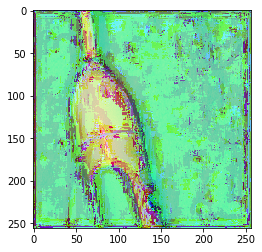

In [43]:
def interpret_prediction(gray, predict):
    H, W, C = gray.shape
    out = np.zeros_like(gray)
    placed_bins = np.argmax(predict, axis=-1)
    pixel_values = inverse_values[placed_bins]
    out[:, :, 0] = gray[:, :, 0]
    out[:, :, 1] = pixel_values[:, :, 0]
    out[:, :, 2] = pixel_values[:, :, 1]
    return out
im =interpret_prediction(showoff_x, prediction)
imshow(im)

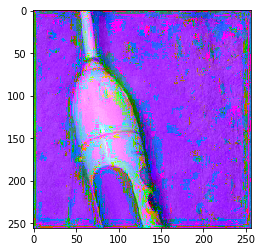

In [44]:
# converting into RGB gives us
im *= 255
imshow(YCCtoRGB(im))

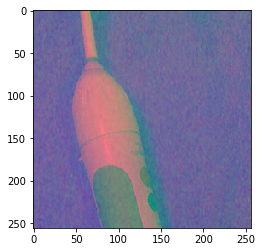

In [45]:
should_be = np.zeros_like(showoff_x)
should_be[:, :, 0] = showoff_x[:, :, 0]
should_be[:, :, 1] = showoff_y[:, :, 0]
should_be[:, :, 2] = showoff_y[:, :, 1]
imshow(should_be)

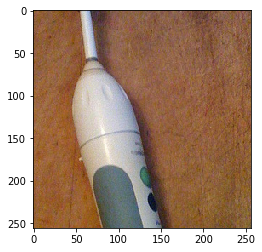

In [46]:
# real image
should_be *= 255
imshow(YCCtoRGB(should_be))